### Positional cross-matching of AGN (Active Galactic Nuclei)

When investigating astronomical objects, like active galactic nuclei (AGN), astronomers compare data about those objects from different telescopes at different wavelengths. This requires positional cross-matching to find the closest counterpart within a given radius on the sky. 

In this activity we cross-match two catalogues: one from a radio survey, the [AT20G Bright Source Sample (BSS) catalogue](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/MNRAS/384/775) and one from an optical survey, the [SuperCOSMOS all-sky galaxy catalogue](http://ssa.roe.ac.uk/allSky). The BSS catalogue lists the brightest sources from the AT20G radio survey while the SuperCOSMOS catalogue lists galaxies observed by visible light surveys. If we can find an optical match for our radio source, we are one step closer to working out what kind of object it is, e.g. a galaxy in the local Universe or a distant quasar. We've chosen one small catalogue (BSS has only 320 objects) and one large one (SuperCOSMOS has about 240 million) to demonstrate the issues you can encounter when implementing cross-matching algorithms.

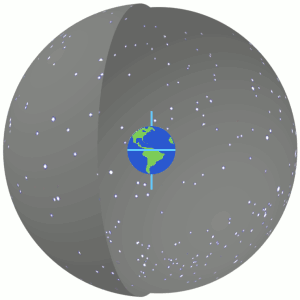

The positions of stars, galaxies and other astronomical objects are usually recorded in either [equatorial](http://astronomy.swin.edu.au/cosmos/E/Equatorial+Coordinate+System) or [Galactic](https://astronomy.swin.edu.au/cosmos/N/North+Galactic+Pole) coordinates. Equatorial coordinates are fixed relative to the celestial sphere, so the positions are independent of when or where the observations took place. They are defined relative to the celestial equator (which is in the same plane as the Earth's equator) and the ecliptic (the path the sun traces throughout the year).

A point on the celestial sphere is given by two coordinates:
- **Right ascension**: the angle from the vernal equinox to the point, going east along the celestial equator. Right ascension is often given in hours-minutes-seconds (HMS) notation, because it was convenient to calculate when a star would appear over the horizon. A full circle in HMS notation is 24 hours, which means 1 hour in HMS notation is equal to 15 degrees. Each hour is split into 60 minutes and each minute into 60 seconds.
- **Declination**: the angle from the celestial equator to the point, going north (negative values indicate going south). Declination is traditionally recorded in degrees-minutes-seconds (DMS) notation. A full circle is 360 degrees, each degree has 60 arcminutes and each arcminute has 60 arcseconds.

The vernal equinox is the intersection of the celestial equator and the ecliptic where the ecliptic rises above the celestial equator going further east.

To crossmatch two catalogues we need to compare the angular distance between objects on the celestial sphere. People loosely call this a "distance", but technically its an angular distance: the projected angle between objects as seen from Earth. In the context of this task we will use the [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula).

In [1]:
# imports
import numpy as np

In [2]:
# HMS to decimal degrees
def hms2dec(hr, m, s):
    dec = hr + m/60 + s/3600
    return dec*15

# DMS to decimal degrees
def dms2dec(d, m, s):
    sign = d/abs(d)
    dec = abs(d) + m/60 + s/3600
    return sign*dec

# import bss data
def import_bss():
    res = []
    data = np.loadtxt('bss.dat', usecols=range(1, 7))
    for i, row in enumerate(data, 1):
        res.append((i, hms2dec(row[0], row[1], row[2]), dms2dec(row[3], row[4], row[5])))
    return res

# import super data
def import_super():
    data = np.loadtxt('super.csv', delimiter=',', skiprows=1, usecols=[0, 1])
    res = []
    for i, row in enumerate(data, 1):
        res.append((i, row[0], row[1]))
    return res

# calculate angular distance using haversine's formula
def angular_dist(ra1, dec1, ra2, dec2):
    # Convert to radians
    r1 = np.radians(ra1)
    d1 = np.radians(dec1)
    r2 = np.radians(ra2)
    d2 = np.radians(dec2)
    a = np.sin(np.abs(d1 - d2)/2)**2
    b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
    angle = 2*np.arcsin(np.sqrt(a + b))
    
    # Convert back to degrees
    return np.degrees(angle)

# find closest object
def find_closest(cat, ra, dec):
    min_dist = np.inf
    min_id = None
    for id1, ra1, dec1 in cat:
        dist = angular_dist(ra1, dec1, ra, dec)
        if dist < min_dist:
            min_id = id1
            min_dist = dist

    return min_id, min_dist

# cross-matching function
def crossmatch(cat1, cat2, max_radius):
    ''' Crossmatches two catalogues within a maximum distance and returns a list
        of matches and non-matches for the first catalogue against the second.
        The list of matches contains tuples of the first and second catalogue 
        object IDs and their distance. The list of non-matches contains the unmatched
        object IDs from the first catalogue only. Both lists are ordered by the 
        first catalogue's IDs. The BSS and SuperCOSMOS catalogues are given as input 
        arguments. The maximum distance is given in decimal degrees.
    '''
    matches = []
    no_matches = []
    for id1, ra1, dec1 in cat1:
        closest_dist = np.inf
        closest_id2 = None
        for id2, ra2, dec2 in cat2:
            dist = angular_dist(ra1, dec1, ra2, dec2)
            if dist < closest_dist:
                closest_id2 = id2
                closest_dist = dist

        # Ignore match if it's outside the maximum radius
        if closest_dist > max_radius:
            no_matches.append(id1)
        else:
            matches.append((id1, closest_id2, closest_dist))

    return matches, no_matches

In [3]:
# import data
bss_cat = import_bss()
super_cat = import_super()

# Example runs
#
# first example in the question
max_dist = 40/3600 # maximum radius
matches, no_matches = crossmatch(bss_cat, super_cat, max_dist)
print('First example:')
print('\tNumber of matches:', len(matches))
print('\tNumber of non matches:', len(no_matches))
print('\tFirst 3 matches:\n\t', matches[:3])

# second example in the question
max_dist = 5/3600 # maximum radius
matches, no_matches = crossmatch(bss_cat, super_cat, max_dist)
print('Second example:')
print('\tNumber of matches:', len(matches))
print('\tNumber of non matches:', len(no_matches))
print('\tFirst 3 matches:\n\t', matches[:3])

First example:
	Number of matches: 169
	Number of non matches: 151
	First 3 matches:
	 [(1, 2, 0.00010988610938710059), (2, 4, 0.0007649845967242495), (3, 5, 0.00020863352870707666)]
Second example:
	Number of matches: 123
	Number of non matches: 197
	First 3 matches:
	 [(1, 2, 0.00010988610938710059), (2, 4, 0.0007649845967242495), (3, 5, 0.00020863352870707666)]
